In [1]:
import numpy as np
import crispr_assembler as ca
import matplotlib.pyplot as plt
import editdistance as ed
import os
import pickle


%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
def get_weights(gr, arrays):
    weights = []
    for a in arrays:
        w = []
        for x, y in zip(a, a[1:]):
            w.append(gr[x, y])
        weights.append(w)
    
    return weights

In [5]:
def get_routes(graph, route, routes, vertex):
    candidates = np.where(graph[vertex] > 0)[0]
    #print(candidates)
    if len(candidates) == 0:
        #print("a", routes)
        routes.append(route)
    else:
        is_final = 1
        for candidate in candidates:
            if not candidate in route:
                is_final = 0
                new_route = [x for x in route]
                new_route.append(candidate)
                #print('n', new_route)
                get_routes(graph, new_route, routes,candidate)
        if is_final:
            #print("a", routes)
            routes.append(route)

In [6]:
def restore_all(graph):
    start_vertexes = np.where(graph.sum(0) == 0)[0]
    
    answ = []
    
    for vertex in start_vertexes:
        routes = []
        route = [vertex]
        get_routes(graph, route, routes, vertex)
        
        answ.extend(routes)
        
    return answ

In [7]:
def make_vertexes_embs(gr):
    embs = np.zeros((gr.flatten().shape[0], 5))
    
    for i in range(embs.shape[0]):
        x, y = i // gr.shape[0], i % gr.shape[0]
        #print(x, y)
        embs[i, 0] = gr[x, y]
        embs[i, 1] = embs[i, 0] /  max(1, gr[x].sum())
        embs[i, 2] = embs[i, 0] /  max(1,gr[:, y].sum())
        
        embs[i, 3] = embs[i, 0] / max(1, gr[:, x].sum())
        embs[i, 4] = embs[i, 0] / max(1, gr[y].sum())
    return embs

In [8]:
def get_percentiles(gr, i, j):
    return [np.where(np.argsort(gr[i]) == j)[0][0] / (gr.shape[0] - 1), \
            np.where(np.argsort(gr[:, j]) == i)[0][0] / (gr.shape[0] - 1)]

In [9]:
def get_ratios(gr, i, j):
    return [gr[i, j] / max(1, gr[i].sum()), gr[i, j] / max(1, gr[:, j].sum())]

In [10]:
def get_median_ratios(gr, i, j):
    return [np.log(gr[i, j] / max(1, np.median(gr[i])) + 1), np.log(gr[i, j] / max(1, np.median(gr[:, j])) + 1)] 

In [11]:
def prepare_embs(gr):
    embs = []
    
    for i in range(gr.shape[0]):
        for j in range(gr.shape[1]):
            emb = []
            emb.extend(get_percentiles(gr, i, j))
            emb.extend(get_ratios(gr, i, j))
            emb.extend(get_median_ratios(gr, i, j))
            embs.append(np.array(emb))
            
    return np.stack(embs) 
            

In [12]:
def calc_metrics_2(gr, gr_r, a):
    spacers = np.array(sorted(list(set([x for x in range(gr_r.shape[0])] + ca.unwrap_nested(a)))))

    reference_gr = (ca.graph_from_arrays(a, len(spacers))[0] > 0).astype(int)
    restored_gr = gr_r[spacers][:, spacers]#(ca.graph_from_arrays(r, len(spacers))[0] > 0).astype(int)
    
    return roc_auc_score(reference_gr.flatten(), restored_gr.flatten()), \
            f1_score(reference_gr.flatten(), restored_gr.flatten()), \
            precision_score(reference_gr.flatten(), restored_gr.flatten()), \
            recall_score(reference_gr.flatten(), restored_gr.flatten())
            
            
    

In [13]:
def do_all_2(f_name, res, answ):
    gr = res.graph_from_pairs()[0]
    embs= make_vertexes_embs(gr.astype(float))
    pred = gb.predict(embs[:, 1:]).reshape(gr.shape)
    print(f_name)
    #r, w = ca.restore_arrays(res[1][0], 5)
    a, d = ca.multiple_arrays_to_ids(answ, res.spacer_to_cluster_index)
    
    print(" & ".join(map(lambda x : "{0:.3f}".format(x), calc_metrics_2(gr, pred, [x for x in a.values()]))))
    
    return pred
    #return r, w, a, d, calc_metrics(res[1][0], r, [x for x in a.values()])

In [57]:
path = '/home/anton/BigMac/skoltech/CRISPR_research/article/data/filtered/'
files = sorted(os.listdir(path))

In [62]:
answer_sensivity = ca.read_arrays_with_tags("../../article/data/answers/sensivity", 0)
answer_all = ca.read_arrays_with_tags("../../article/data/answers/all", 0)

2,3,5,7,8,11,14,15,21,22

strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

# Calc answ

In [16]:
def restore(path, minimum_occurences = 0):
    read = ca.Read(path)
    read.correct_errors(minimum_occurences = minimum_occurences)
    #gr = read.graph_from_pairs()

    return read#, gr

In [17]:
files

['ES1.merged.assembled.fastq',
 'ES2.merged.assembled.fastq',
 'ES3.merged.assembled.fastq',
 'ES4.merged.assembled.fastq',
 'ES5.merged.assembled.fastq',
 'ES6.merged.assembled.fastq',
 'd24.merged.assembled.fastq',
 'd25.merged.assembled.fastq',
 'd26.merged.assembled.fastq',
 'd27.merged.assembled.fastq',
 'planA.merged.assembled.fastq',
 'sensivity.merged.assembled.fastq']

In [18]:
sorted(files)[-1:]

['sensivity.merged.assembled.fastq']

In [19]:
res = restore(path + sorted(files)[-1], 5) 

100%|██████████| 2409/2409 [00:00<00:00, 2960.31it/s]


In [63]:
a, d = ca.multiple_arrays_to_ids(answer_sensivity, res.spacer_to_cluster_index)

a_all, d_all = ca.multiple_arrays_to_ids(answer_all, res.spacer_to_cluster_index)

100%|██████████| 54/54 [00:02<00:00, 23.34it/s]


In [71]:
answ_gr = ca.graph_from_arrays([x for x in a.values()], gr.shape[0])[0]

In [23]:
#gb_old = pickle.load(open("../gb_model", "rb"))
gb = pickle.load(open("./gb_rep_to_rep", "rb"))

In [24]:
gr = res.graph_from_pairs()[0]

In [27]:
ec = ca.EmbeddingsCalculator()
embs = ec.fit_predict(gr)

In [28]:
pred = gb.predict(embs)

In [29]:
graph_restored_ml = pred.flatten().reshape(gr.shape)

In [31]:
a_full_ml, a_ml = ca.restore_arrays_all(graph_restored_ml, 1)

In [36]:
a_gr, w_gr = ca.restore_arrays_greedy(gr)

In [37]:
graph_restored_gr = ca.graph_from_arrays(a_gr, gr.shape[0])[0]

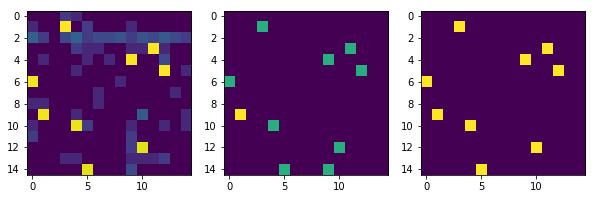

In [72]:
cut1, cut2 = 50, 65
ca.plot_grs(gr[cut1:cut2, cut1:cut2], answ_gr[cut1:cut2, cut1:cut2], graph_restored_ml[cut1:cut2, cut1:cut2], log = 1, s = 10)

In [68]:
res.index_to_cluster[7]

'TCGTCAGGGCACAATAACTGAGGTTCGCA'

In [77]:
for i, x in enumerate(ca.get_weights(gr, [x for x in a_ml if len(x) > 1])):
    print(i)
    print(x)

0
[40, 335, 363, 313, 254, 419, 534, 411, 463, 524, 485, 551, 525, 410, 388, 404, 295, 222]
1
[673, 1612, 3599, 5802, 12920, 14435, 12161, 18820, 18200, 15844, 18144, 10367, 17188, 12932, 11542, 15316]
2
[5491, 5550, 7902, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 1200, 1845, 1732, 3795, 1857]
3
[279, 39, 3174, 349, 601, 490, 585, 642, 389, 360, 346, 7, 13, 6]
4
[673, 1612, 3599, 5802, 12920, 310, 18200, 15844, 18144, 10367, 17188, 12932, 11542, 15316]
5
[5491, 5550, 7902, 7389, 7254, 6007, 7294, 10495, 10251, 5448, 5465, 6230, 4275]
6
[11, 85, 24, 17, 19, 22, 21, 10, 9]
7
[284, 184, 360, 348, 377, 172, 253, 344, 149]
8
[6, 16, 194, 192, 250, 256, 74, 50]
9
[2359, 1945, 2260, 1200, 1845, 1732, 3795, 1857]
10
[12, 17, 12, 18, 9, 6, 1]
11
[38, 129, 111, 91, 127, 76, 41]
12
[117, 145, 135, 1983, 2166, 1134]
13
[2359, 1945, 2260, 5465, 6230, 4275]
14
[62, 13, 18, 19, 12]
15
[398, 493, 1230, 780, 372]
16
[192, 165, 97, 29]


In [76]:
[(i, x) for i, x in enumerate(a_ml) if len(x) > 1]

[(0,
  [127,
   79,
   67,
   77,
   81,
   64,
   55,
   62,
   60,
   54,
   59,
   51,
   53,
   61,
   65,
   63,
   74,
   87,
   92]),
 (1, [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9]),
 (2, [23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 40, 39, 29, 30, 42]),
 (3, [85, 86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80, 165, 174, 191]),
 (4, [46, 37, 28, 21, 10, 5, 1, 4, 2, 6, 3, 8, 12, 7, 9]),
 (5, [23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27]),
 (6, [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]),
 (7, [70, 90, 69, 71, 68, 78, 89, 75, 83, 98]),
 (8, [197, 163, 95, 93, 82, 84, 91, 115, 117]),
 (9, [33, 36, 32, 25, 40, 39, 29, 30, 42]),
 (10, [145, 149, 148, 153, 152, 177, 169, 200]),
 (11, [123, 99, 104, 106, 100, 108, 114, 124]),
 (12, [105, 88, 97, 38, 34, 41, 45]),
 (13, [33, 36, 32, 25, 22, 26, 27]),
 (14, [70, 118, 157, 150, 146, 166]),
 (15, [66, 57, 43, 44, 47, 72]),
 (16, [94, 96, 101, 110, 130])]

In [114]:
[x for x in a.values()]

[[127, 79, 67, 81, 64, 59, 51],
 [85, 197, 163, 95, 93],
 [95, 93, 82, 84, 91, 115, 117],
 [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80],
 [33, 36, 32, 25, 40, 39, 29, 30, 42],
 [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191],
 [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6],
 [127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92],
 [46, 37, 28, 21, 10, 5, 1, 3],
 [85, 109, 112, 143, 144, 141, 139, 155, 170, 180, 21],
 [23, 145, 149, 148, 153, 152, 177, 169, 200],
 [66, 57, 43, 44, 47, 72],
 [105, 66, 88, 97, 70, 118, 157, 150, 146, 166],
 [123, 99, 104, 106, 100, 108, 114, 124],
 [105, 88, 97, 38, 34, 41, 45],
 [27, 0, 122, 49, 116, 14],
 [23, 96, 101, 110, 185],
 [23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26],
 [23, 94, 96, 101, 110, 130],
 [105, 88, 97, 70, 90, 69, 71, 68, 78, 89, 5, 68, 78, 89, 75, 83, 98]]

In [55]:
for i in range(100):
    if i not in ca.unwrap_nested([x for x in a.values()]):
        print(i)

7
8
9
12
52


In [79]:
for key in a:
    allignments_gr = ca.print_alignments(ca.water_alignments(a[key], a_gr), a[key])
    allignments_ml = ca.print_alignments(ca.water_alignments(a[key], a_ml), a[key])
#     mask = np.array(occurrences)[np.array(a[key])]
#     print(mask)
    #print("Answer:", ca.get_weights(gr, [a[key]]))
    #print("Answer:", ca.get_weights(gr, [np.array(a[key])])#mask == 1]]))
    print(key)
    print("Answer:", allignments_gr[0])
    
    
    for x in allignments_gr[1:]:
        print('r gdy :', x)
        
    print("Answer:", allignments_ml[0])
    for x in allignments_ml[1:]:
        print('r soft:', x)
    print('____________________________')

first_11
Answer:  127, 79 , 67 , 81 , 64 , 59 , 51 ,
r gdy :  127, 79 , 67 , 77 , 81 , 64 , 55 , 62 , 60 , 54 , 59 , 51 , 53 , 61 , 65 , 63 , 74 , 87 , 92 ,
Answer:  127, 79 , 67 , 81 , 64 , 59 , 51 ,
r soft:  127, 79 , 67 , 77 , 81 , 64 , 55 , 62 , 60 , 54 , 59 , 51 , 53 , 61 , 65 , 63 , 74 , 87 , 92 ,
____________________________
first_2
Answer:  85 , 197, 163, 95 , 93 ,
r gdy :  -  , 197, 163, 95 , 93 , 82 , 84 , 91 , 115, 117,
Answer:  85 , 197, 163, 95 , 93 ,
r soft:  -  , 197, 163, 95 , 93 , 82 , 84 , 91 , 115, 117,
____________________________
first_3
Answer:  -  , -  , 95 , 93 , 82 , 84 , 91 , 115, 117,
r gdy :  197, 163, 95 , 93 , 82 , 84 , 91 , 115, 117,
Answer:  -  , -  , 95 , 93 , 82 , 84 , 91 , 115, 117,
r soft:  197, 163, 95 , 93 , 82 , 84 , 91 , 115, 117,
____________________________
first_5
Answer:  -  , 86 , 31 , 35 , 49 , 56 , 50 , 48 , 58 , 73 , 76 , 80 ,
r gdy :  85 , 86 , 31 , 35 , 49 , 56 , 50 , 48 , 58 , 73 , 76 , 80 , 165, 174, 191,
Answer:  -  , 86 , 31 , 35 , 

In [147]:
def print_allignment_to_int_allignment(seq):
    int_seq = []
    
    for x in seq:
        c = int(x.strip())
        int_seq.append(c)
    
    return int_seq

In [148]:
print_allignment_to_int_allignment(allignments_gr[0])

ValueError: invalid literal for int() with base 10: ''

In [132]:
allignments_gr[0] == allignments_gr[1]


False

In [142]:
def calc_metric(allignment):
    allignment = [np.array(x) for x in allignment]
    
    target = allignment[0]
    print(target)
    for a in allignment[1:]:
        mask = np.where(a == target)# & a != ' -  '
        print(a)
        print(mask)

In [143]:
calc_metric(allignments_gr)

[array(' 105, 88 , 97 , 70 , 90 , 69 , 71 , 68 , 78 , 89 , 5  , 68 , 78 , 89 , 75 , 83 , 98 ,',
      dtype='<U85'), array(' 105, 88 , 97 , 38 , 34 , 41 , 45 , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  ,',
      dtype='<U85'), array(' -  , -  , 113, 70 , 90 , 69 , 71 , 68 , 78 , 89 , 75 , 83 , 98 , -  , -  , -  , -  ,',
      dtype='<U85')]
 105, 88 , 97 , 70 , 90 , 69 , 71 , 68 , 78 , 89 , 5  , 68 , 78 , 89 , 75 , 83 , 98 ,
 105, 88 , 97 , 38 , 34 , 41 , 45 , -  , -  , -  , -  , -  , -  , -  , -  , -  , -  ,
(array([], dtype=int64),)
 -  , -  , 113, 70 , 90 , 69 , 71 , 68 , 78 , 89 , 75 , 83 , 98 , -  , -  , -  , -  ,
(array([], dtype=int64),)


In [ ]:
from sklearn.metrics 

In [130]:
compute_bleu([[str(x) for x in [127, 79 , 67 , 81 , 64 , 59 , 51]]],
             [str(x) for x in [127, 79 , 67 , 77 , 81 , 64 , 55 , 62 , 60 , 54 , 59 , 51 , 53 , 61 , 65 , 63 , 74 , 87 , 92]], 4)

(0.0, [1.0, 1.0, 1.0, 0.0], 1.0, 1.5, 3, 2)

In [126]:
compute_bleu([['aaaa', 'aaaa', 'aaaa', 'aaaa']],
             ['aaaa', 'aaaa', 'aaaa', 'aaaa'])

(1.0, [1.0, 1.0, 1.0, 1.0], 1.0, 1.0, 4, 4)

In [ ]:
"Returns:\ 
3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram\
precisions and brevity penalty."

In [115]:
import collections
import math


def _get_ngrams(segment, max_order):
    """Extracts all n-grams upto a given maximum order from an input segment.
    Args:
      segment: text segment from which n-grams will be extracted.
      max_order: maximum length in tokens of the n-grams returned by this
          methods.
    Returns:
      The Counter containing all n-grams upto max_order in segment
      with a count of how many times each n-gram occurred.
    """
    ngram_counts = collections.Counter()
    for order in range(1, max_order + 1):
        for i in range(0, len(segment) - order + 1):
            ngram = tuple(segment[i:i + order])
            ngram_counts[ngram] += 1
    return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
    """Computes BLEU score of translated segments against one or more references.
    Args:
      reference_corpus: list of lists of references for each translation. Each
          reference should be tokenized into a list of tokens.
      translation_corpus: list of translations to score. Each translation
          should be tokenized into a list of tokens.
      max_order: Maximum n-gram order to use when computing BLEU score.
      smooth: Whether or not to apply Lin et al. 2004 smoothing.
    Returns:
      3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
      precisions and brevity penalty.
    """
    matches_by_order = [0] * max_order
    possible_matches_by_order = [0] * max_order
    reference_length = 0
    translation_length = 0
    for (references, translation) in zip(reference_corpus,
                                         translation_corpus):
        reference_length += min(len(r) for r in references)
        translation_length += len(translation)

        merged_ref_ngram_counts = collections.Counter()
        for reference in references:
            merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
        translation_ngram_counts = _get_ngrams(translation, max_order)
        overlap = translation_ngram_counts & merged_ref_ngram_counts
        for ngram in overlap:
            matches_by_order[len(ngram) - 1] += overlap[ngram]
        for order in range(1, max_order + 1):
            possible_matches = len(translation) - order + 1
            if possible_matches > 0:
                possible_matches_by_order[order - 1] += possible_matches

    precisions = [0] * max_order
    for i in range(0, max_order):
        if smooth:
            precisions[i] = ((matches_by_order[i] + 1.) /
                             (possible_matches_by_order[i] + 1.))
        else:
            if possible_matches_by_order[i] > 0:
                precisions[i] = (float(matches_by_order[i]) /
                                 possible_matches_by_order[i])
            else:
                precisions[i] = 0.0

    if min(precisions) > 0:
        p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
        geo_mean = math.exp(p_log_sum)
    else:
        geo_mean = 0

    ratio = (float(translation_length) / reference_length) if reference_length > 0 else 0.0

    if ratio > 1.0:
        bp = 1.
    else:
        bp = math.exp(1 - 1. / ratio) if ratio > 0 else 0.0

    bleu = geo_mean * bp

    return (bleu, precisions, bp, ratio, translation_length, reference_length)

In [78]:
ca.get_top_stats(gr, 15)

(array([5448,   98,   44,   31,   29,   24,   22,   22,   21,   20]),
 array([ 25, 131,   3,  13,  11,  20,   6,  14,   4,   2]))

In [112]:
p = ca.get_weights(gr, [[  85 , 86 , 31 , 35 , 49 , 56 , 50 , 48 , 58 , 73 , 76 , 80 , 165, 174, 191 ]])
some_stat(p, 1)

[ 279   39 3174  349  601  490  585  642  389  360  346    7   13    6]


0.24180305571275368

In [84]:
q = ca.get_weights(gr, [[ 23 , 24 , 16 , 18 , 19 , 20 , 17 , 13 , 14 , 15 , 25 , 40 , 39 , 29 , 30 , 42]]) 

In [107]:
def some_stat(x, v = 0):
    #print(x)
    x =np.array(ca.unwrap_nested(x))
    if v : print(x)
    return np.std(x / max(x))

In [108]:
for _ in [x for x in a.values()]:
    print(some_stat(_))

0.18277494100192201
0.22858652030144155
0.1106607087704244
0.20208806787915978
0.12698412698412698
0.2801696058746271
0.31852648395853495
0.13881215422612322
0.3432851514114529
0.2361520247596489
0.2335329833684905
0.1545388123192085
0.20973979690734748
0.07311074340511592
0.2744255123707963
0.39217882939567733
0.2780081505550121
0.16003702173134346
0.25569129973985455
0.20310421969775855


In [100]:
some_stat(ca.get_weights(gr, [[ 33 , 36 , 32 , 25 , 22 , 26 , 27  ]]))

[[2359, 1945, 2260, 5465, 6230, 4275]]
[2359, 1945, 2260, 5465, 6230, 4275]


0.26843128227390267

In [43]:
graph_restored_gb[5, 1]

0

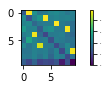

In [45]:
ca.plot_gr(gr[:10, :10], log = 1)

In [28]:
ca.water_alignments(a['first_2'], arrs)

array([[list([197, 163, 95, 93]),
        list([197, 163, 95, 93, 82, 84, 91, 115, 117]),
        list([197, 163, 95, 93]), list([197, 163, 95, 93]), 0, 4, 0, 4,
        1.0, 0.4444444444444444, 40.0]], dtype=object)

In [27]:
a

{'first_2': [197, 163, 95, 93],
 'first_3': [95, 93, 82, 84, 91, 115, 117],
 'first_5': [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80],
 'first_7': [33, 36, 32, 25, 40, 39, 29, 30, 42],
 'first_8': [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191],
 'first_11': [127, 79, 67, 81, 64, 59, 51],
 'first_14': [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9],
 'first_15': [127,
  79,
  67,
  77,
  81,
  64,
  55,
  62,
  60,
  54,
  59,
  51,
  51,
  53,
  61,
  65,
  63,
  74,
  87,
  92],
 'first_21': [85, 109, 112, 143, 144, 141, 139, 155, 170, 180, 21],
 'first_22': [46, 37, 28, 21, 10, 5, 1, 3],
 'second_2': [23, 145, 149, 148, 153, 152, 177, 169, 200],
 'second_3': [123, 99, 104, 106, 100, 108, 114, 124],
 'second_5': [66, 57, 43, 44, 47, 72],
 'second_7': [105, 88, 97, 38, 34, 41, 45],
 'second_8': [66, 57, 43, 44, 47, 72],
 'second_11': [23, 96, 101, 110, 110],
 'second_14': [23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27],
 'second_15': [23, 94, 96, 101, 110, 130],

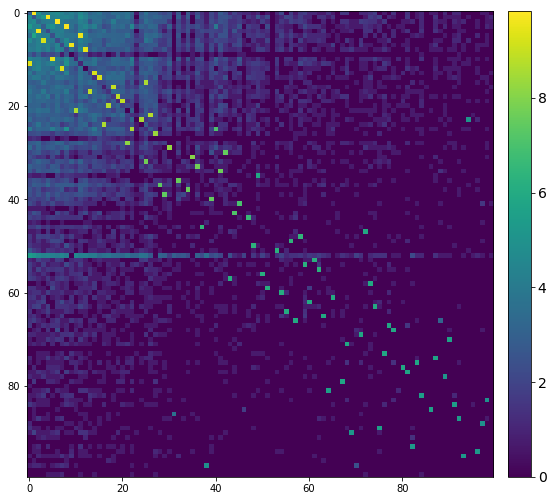

In [56]:
c1, c2, = 0, 100
ca.plot_gr(gr[c1:c2, c1:c2].astype(int), 
           log = 1,
           s = 14)

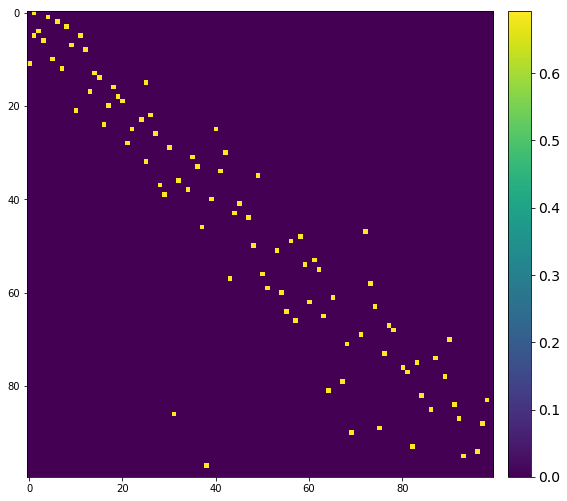

In [57]:
c1, c2, = 0, 100
ca.plot_gr(graph_restored_new[c1:c2, c1:c2].astype(int), 
           log = 1,
           s = 14)

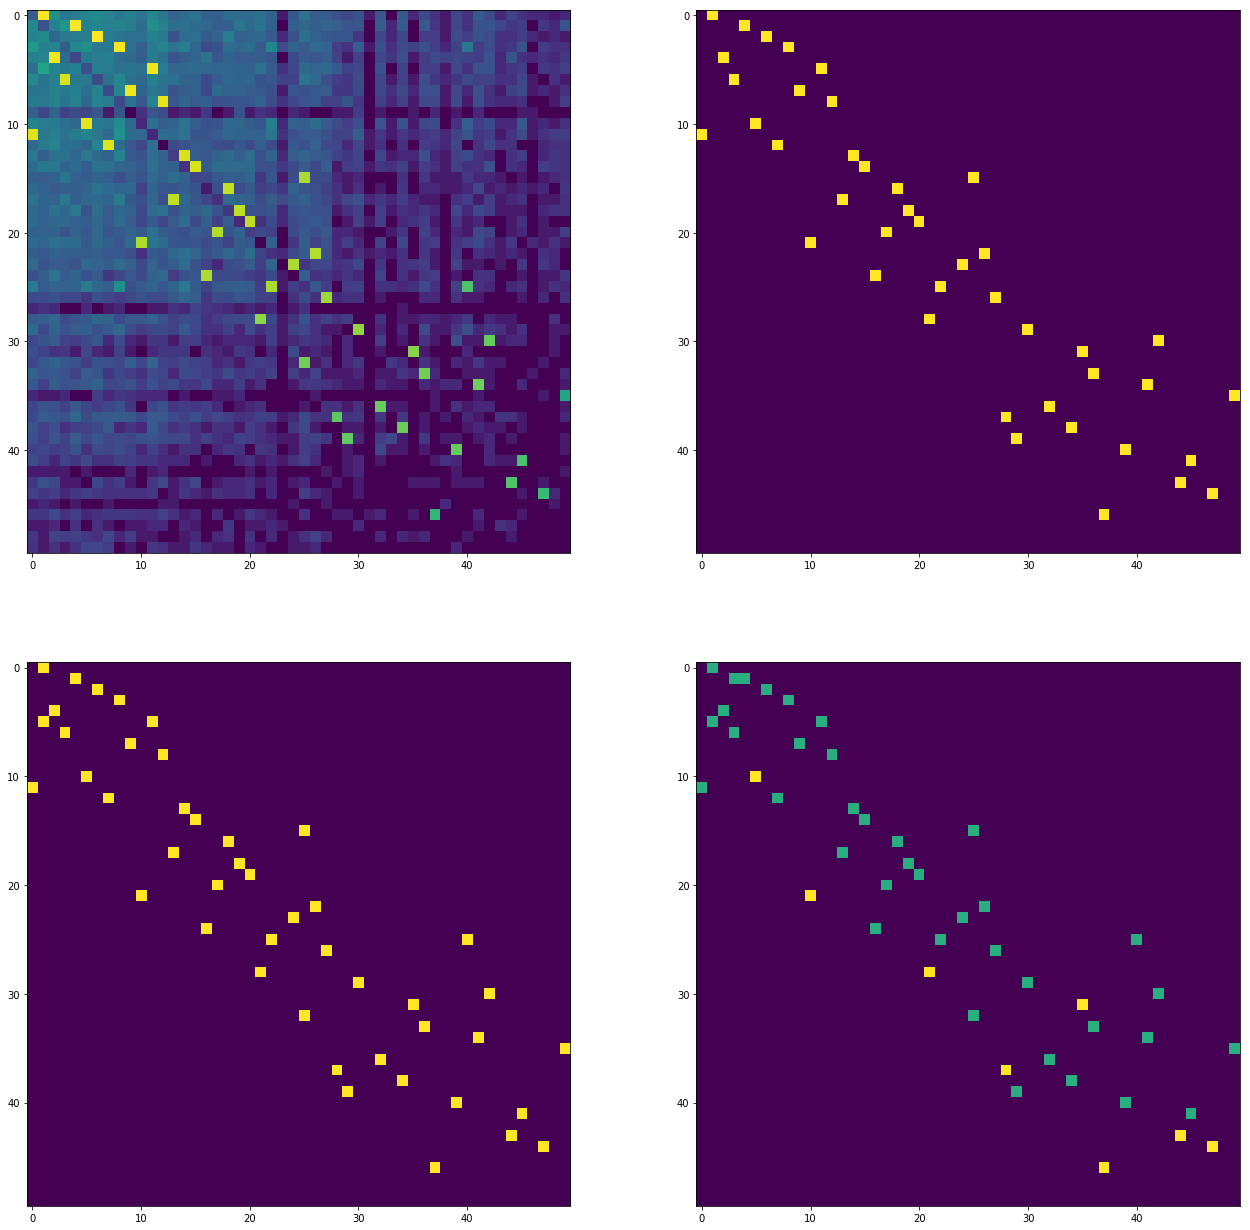

In [53]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2].astype(int),
            graph_restored[c1:c2, c1:c2],
            graph_restored_new[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 22,
            subplots_form = (2,2))

In [23]:
restored_arrays = [x for x in restore_all(graph_restored) if len(x) > 1]
weights = get_weights(gr, restored_arrays)

In [24]:
# for ra,wa  in zip(restored_arrays, weights):
#     print(ra)
#     print(wa)
#     print("--------------------------------------------")

In [15]:
restored_arrays_filtered = [[23, 24, 16, 18, 19, 20, 17, 13, 14, 15, 25, 22, 26, 27],
                            [40, 39, 29, 30, 42],
                            [23, 94, 96, 101, 110, 130],
                            [23, 145, 149, 148, 153, 152, 177, 169, 200],
                            [31, 35, 49, 56, 50, 48, 58, 73, 76],
                            [80, 165, 174, 191],
                            [33, 36, 32],
                            [38, 34, 41, 45],
                            [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9],
                            [70, 90, 69, 71, 68, 78, 89, 75, 83, 98],
                            [70, 118, 157, 150, 146, 166],
                            [85, 109, 112, 143, 144, 141, 139, 155, 170, 180],
                            [105, 66, 57, 43, 44, 47, 72],
                            [123, 99, 104, 106, 100, 108, 114, 124],
                            [127, 79, 67, 77, 81, 64, 55, 62, 60, 54, 59, 51, 53, 61, 65, 63, 74, 87, 92],
                            [197, 163, 95, 93, 82, 84, 91, 115, 117]]



In [26]:
restored_gr_filtered = ca.graph_from_arrays(restored_arrays_filtered, 500)[0]

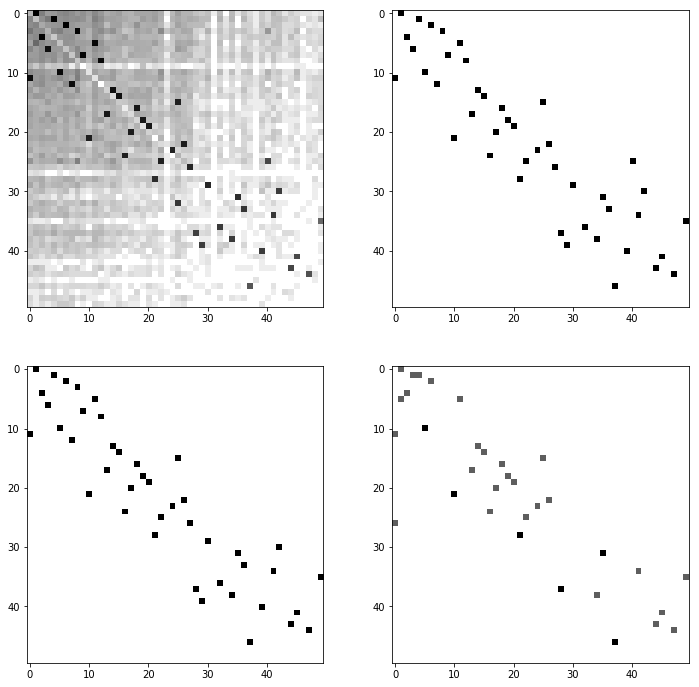

In [54]:
c1, c2, = 0, 50

ca.plot_grs(gr[c1:c2, c1:c2],
            graph_restored[c1:c2, c1:c2],
            restored_gr_filtered[c1:c2, c1:c2],
            answ_gr[c1:c2, c1:c2],
            
            log = 1,
            s = 12, 
            subplots_form = (2,2))

In [111]:
restored_gr_filtered[66,88]

0

In [21]:
restored_arrays_filtered_dict = dict(zip(np.arange(len(restored_arrays_filtered)), restored_arrays_filtered))

In [71]:
res.corrector.index_to_cluster[59]

'GCATCCATGCCGACGCCTTTACGTGTGCG'

In [72]:
res.corrector.index_to_cluster[55]

'GAGAGTGCTGACAGGTGTCTCGATTACCT'

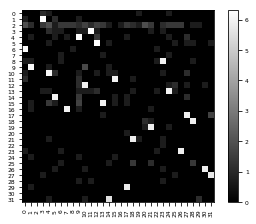

In [78]:
ca.plot_gr(gr[50:82, 50:82], all_ticks=1, log =1)

In [85]:
print(get_weights(gr, [[86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [31, 35, 49, 56, 50, 48, 58, 73, 76]]))


[[39, 3174, 1, 585, 642, 389, 360, 346, 7, 13, 6], [3174, 349, 601, 490, 585, 642, 389, 360]]


In [22]:
def search_ays_in_b(a, b, gr):
    res = []
    for a_name, a_array in a.items():
        matched_parts, b_name, positions = ca.search_best_alignment(
            a_array,
            b)

        res.append(ca.Match(a_name,
             b_name,
             len(matched_parts[0]) / len(a_array),
             len(matched_parts[1]) / len(b[b_name]),
             a_array,
             b[b_name],
             get_weights(gr, [a_array]),
             get_weights(gr, [b[b_name]])))
        
        res[-1].print()
    
    return res

In [23]:
sorted([x.name_2 for x in comp_log])

NameError: name 'comp_log' is not defined

In [26]:
comp_log = search_ays_in_b(a, restored_arrays_filtered_dict, gr)

searched name: first_2
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.5555555555555556
 arrs (search, found): 
[197, 163, 95, 93]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[6, 16, 194]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____________________

searched name: first_3
 found name: 15
 searched_overlap: 1.0
 found_overlap: 0.8888888888888888
 arrs (search, found): 
[95, 93, 82, 84, 91, 115, 117]
[197, 163, 95, 93, 82, 84, 91, 115, 117]
 weights (search, found):
[[194, 192, 250, 256, 74, 50]]
[[6, 16, 194, 192, 250, 256, 74, 50]]
 _____________________

searched name: first_5
 found name: 4
 searched_overlap: 0.9090909090909091
 found_overlap: 1.0
 arrs (search, found): 
[86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80]
[31, 35, 49, 56, 50, 48, 58, 73, 76]
 weights (search, found):
[[39, 3174, 349, 601, 490, 585, 642, 389, 360, 346]]
[[3174, 349, 601, 490, 585, 642, 389, 360]]
 _____________________

searched name: first_7
 found name: 1
 searched_overlap

In [101]:
d

{'first_11': [3, 1, 0, 1, 0, 0, 1],
 'first_2': [2, 5, 4, 4, 3],
 'first_3': [3, 2, 2, 2, 2, 2, 3],
 'first_5': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'first_7': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2],
 'first_8': [1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2],
 'first_14': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'first_15': [3, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 2],
 'first_22': [1, 0, 0, 0, 0, 0, 0, 0],
 'first_21': [1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 12],
 'second_2': [0, 2, 2, 2, 2, 2, 2, 2, 2],
 'second_5': [3, 1, 2, 1, 2, 2],
 'second_21': [3, 3, 2, 2, 3, 2, 3, 3, 3, 3],
 'second_3': [3, 2, 1, 1, 1, 1, 1, 2],
 'second_7': [2, 1, 1, 0, 0, 0, 0],
 'second_8': [15, 13, 13, 13, 15, 14],
 'second_11': [0, 1, 1, 1, 13],
 'second_14': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'second_15': [0, 1, 1, 1, 1, 2],
 'second_22': [1, 2, 0, 0, 1, 1, 0, 1, 1]}

In [110]:
','.join([res.corrector.index_to_cluster[x] for x in [46, 37, 28, 21, 10, 5, 11, 0, 1, 4, 2, 6, 3, 8, 12, 7, 9]])

'ACATGAATGTCGGTTCAGACCGTGTTTTT,AGTGCTGGACCATTTCAAATTCACAATAG,GGAATGATATTTCAATAAATAATTATAAC,TTTTTGTTAATTGCGTTTGCCACGGTTTG,TGAGCGTCGGCGGCTCGCTGGATTTGCG,AATGCATCAGTTGAACACAAAAGTAGCTT,TTTTGCTGACACCGGCAATACTGAACGGC,ACGGATTGCGGTATATGCAGTGTCCAGAT,TAAACCACCAGCCAGACCACCAATTACCA,GGGGATAACGGTTATCCACTGGCCGCCGA,TGTAATAGCCTGATCTCTGATCTCCCTCG,CTGTCCCAGGCCGAGGCTGTATTTCAATCC,GCGATGGATCAGGGTATTACACTCGACGG,GCTGCGGGTCAATCAACTGGAGTGCAAATC,GTCGCGCGCCGACGGAATAAACCGAATAA,TCGTCAGGGCACAATAACTGAGGTTCGCA,AGCAACGCGTAAACCAGATCGCCGATCGTG'

In [57]:
for key in a.keys():
    print(key, a[key])
    print(search_ays_in_b(a[key], restored_arrays_filtered_dict))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


AttributeError: module 'crispr_assembler' has no attribute 'search_ays_in_b'

In [58]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]


NameError: name 'restored' is not defined

In [36]:
for key in a.keys():
    print(key, a[key])
    print(ca.search_best_alignment(a[key], restored))
    print("_____________________________________")

first_11 [127, 79, 67, 81, 64, 59, 51]
(([127, 79, 67, 81, 64], [127, 79, 67, 77, 81, 64]), 47, (0, 5, 0, 6))
_____________________________________
first_2 [85, 197, 163, 95, 93]
(([85, 197, 163, 95, 93], [197, 163, 95, 93]), 48, (0, 5, 0, 4))
_____________________________________
first_3 [95, 93, 82, 84, 91, 115, 117]
(([95, 93, 82, 84, 91, 115, 117], [163, 95, 93, 82, 84, 91, 115, 117]), 48, (0, 7, 1, 9))
_____________________________________
first_5 [86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80]
(([86, 31, 35, 49, 56, 50, 48, 58, 73, 76, 80], [31, 35, 49, 56, 50, 48, 58, 73, 76, 80]), 18, (0, 11, 0, 10))
_____________________________________
first_7 [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]
(([85, 109, 112, 143, 144, 141, 139, 155, 170, 180], [85, 109, 112, 143, 144, 141, 139, 155, 170, 180]), 41, (0, 10, 0, 10))
_____________________________________
first_8 [86, 31, 35, 50, 48, 58, 73, 76, 80, 165, 174, 191]
(([35, 50, 48, 58, 73, 76, 80, 165, 174, 191], [56, 50, 48, 58, 73, 

In [113]:
ca.dict_to_csv(ca.revert_dict(res.cluster_to_index), "./sensitivity_idx_to_sp")

In [121]:
with open("./sensitivity_restored", 'w') as f:
    for k,v in restored_arrays_filtered_dict.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join([ca.revert_dict(res.cluster_to_index)[x] for x in v]))
        f.write("\n")

In [125]:
with open("./sensitivity_answer", 'w') as f:
    for k,v in answer_sensivity.items():
        f.write(str(k))
        f.write("\n")
        f.write("\t".join(v))
        f.write("\n")

In [124]:
answer_sensivity

{'first_11': ['AAAACCAAACTTCTCCATAAATTCCATAGCCG',
  'GAGTCTATCAGCGACACTACCGGCAATAGCGA',
  'CTATAGCGCCACGTTCCGAGCGCTGCGAGCTG',
  'CTAATGAGTCAGTTTGAACAGATCCCCGACAA',
  'GGCTTTAAAATTGTGTTCCCGTCTGGCGCTGG',
  'GCATCCATGCCGACGCCTTTACGTGTGCGGGG',
  'GCGCGAATTTGTGCGCATGGGGCGCATTTTTGG'],
 'first_2': ['TCTAAGTGATATCCATCATCGCATCCAGTGCGCC',
  'TCTTACTGCTTGGTATGCGGAATCACACCCTGAA',
  'ACTGAAGCATCAAACATTTGGTGGACCAAACGGA',
  'ACTGTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'ACGGATCTGCCAGCGCCTCTGCGGGGCGGTAAAC'],
 'first_3': ['GTACGCGGCGAGTTTTAGCGACAGGTCATCC',
  'GATCTGCCAGCGCCTCTGCGGGGCGGTAAAC',
  'ACGCCAGCCACCTGCTTCGCCAGCCGTTCGG',
  'CACGGTAGCGCCACTGCGCGTCGGTGACGGG',
  'ACGAACAGGGATTTGTCGGCAGTTTCTTTAC',
  'TAATTCGCAAATCAATATATATTTTGTCCGT',
  'ATTGCGGATGCTCCCGGAATTGCGCGGGCAA'],
 'first_5': ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
  'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
  'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
  'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
  'ATCGTCCATATTAACAATCGTGGTGAGTTCAA',
  'ACTATGGCCCCGGCAAAAAACGCGCTGGTGGG'

In [114]:
res.dump("./sensitivity_res")

In [ ]:
ca.Comparator(restored, a, sp_to_id)

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception i

Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: object of type 'numpy.int64' has no len()
Exception ignored in: 'editdistance.bycython.eval'
TypeError: ob

## True arrays

In [26]:
gr = res[0].graph_from_pairs()[0]

first_11


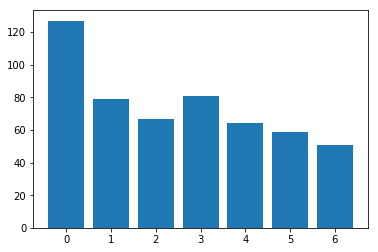

first_2


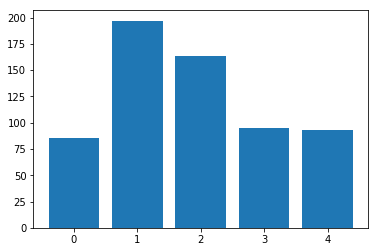

first_3


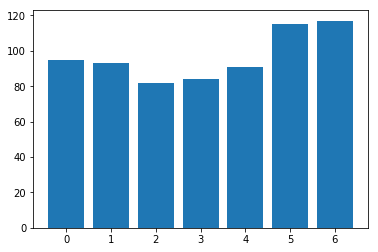

first_5


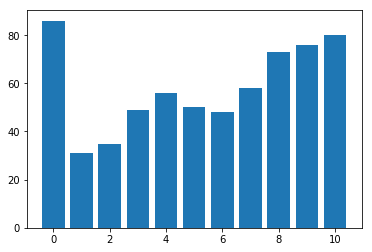

first_7


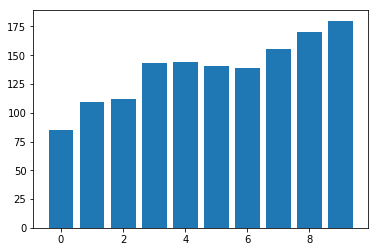

first_8


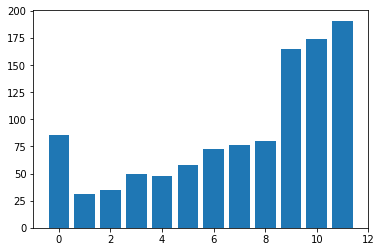

first_14


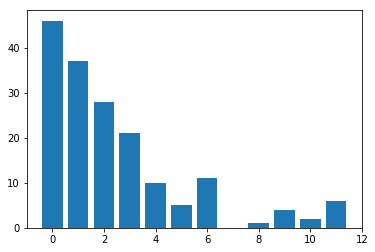

first_15


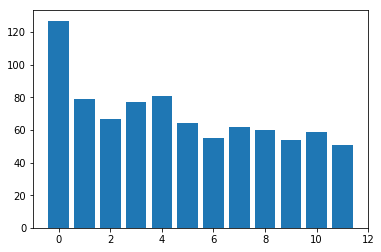

first_22


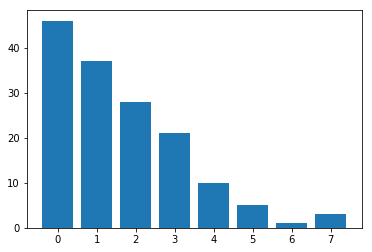

first_21


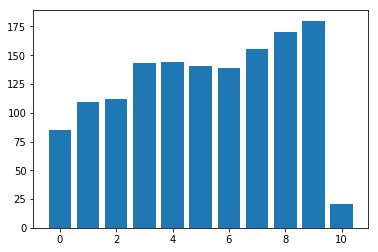

second_2


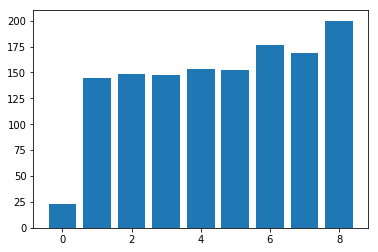

second_5


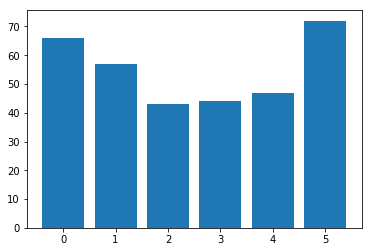

second_21


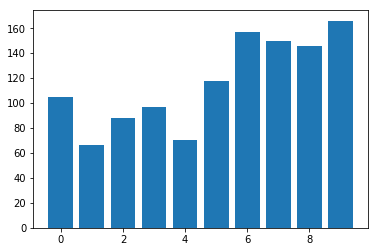

second_3


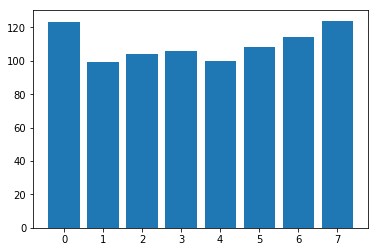

second_7


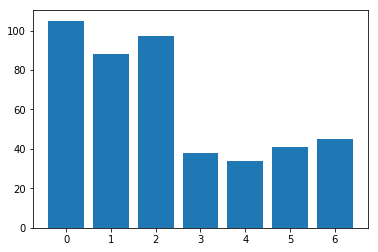

second_8


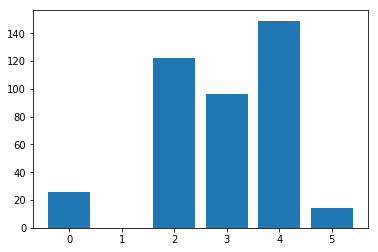

second_11


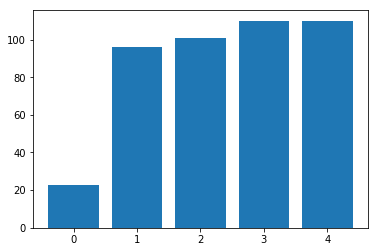

second_14


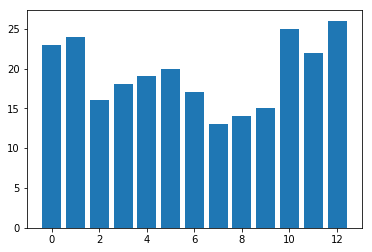

second_15


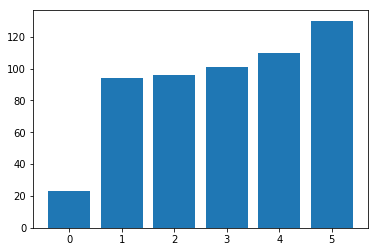

second_22


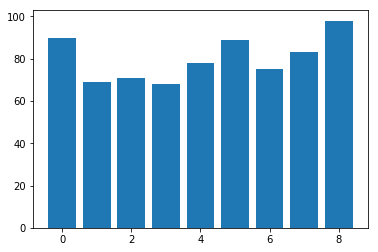

In [18]:
for key, arr in a.items():
    print(key)
    plt.bar(np.arange(len(arr)), arr)
    plt.show()

first_11


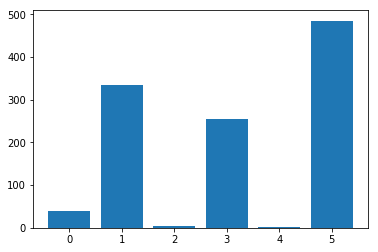

first_2


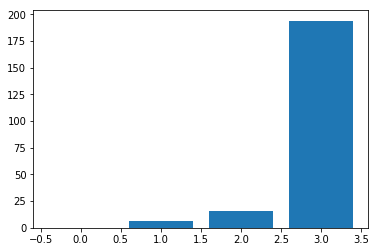

first_3


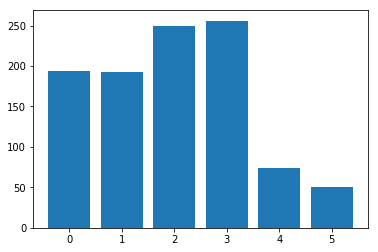

first_5


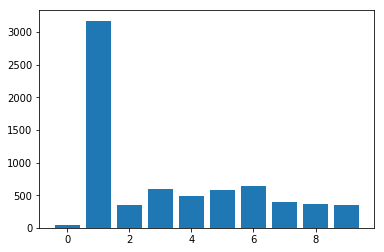

first_7


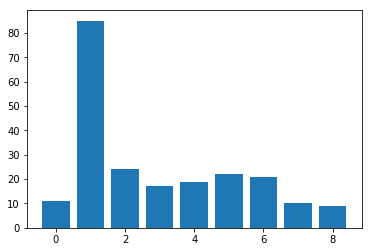

first_8


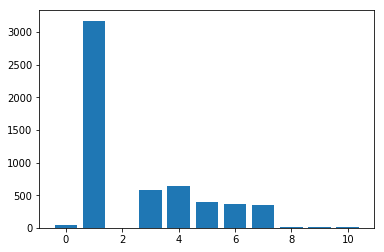

first_14


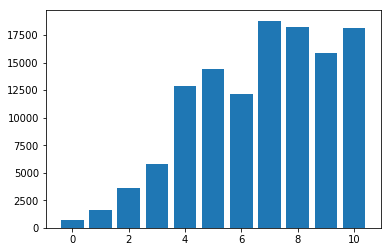

first_15


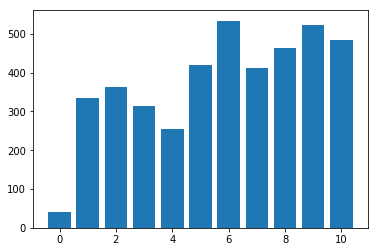

first_22


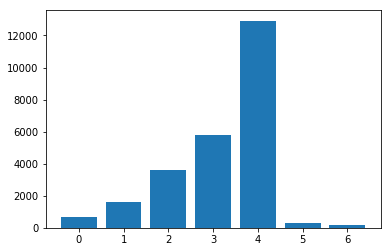

first_21


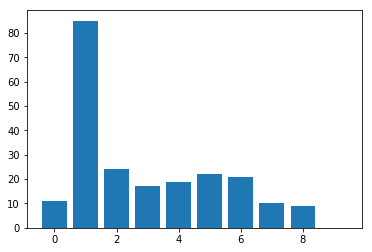

second_2


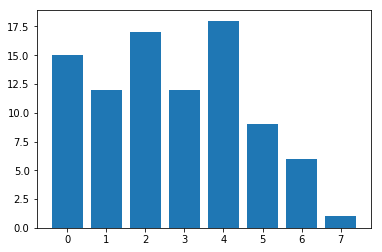

second_5


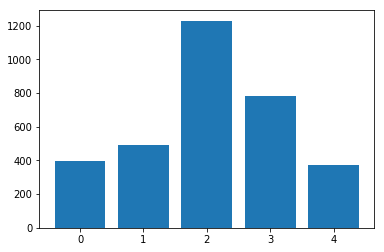

second_21


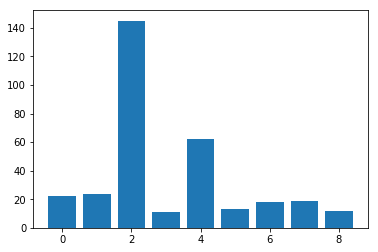

second_3


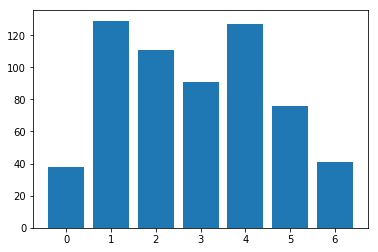

second_7


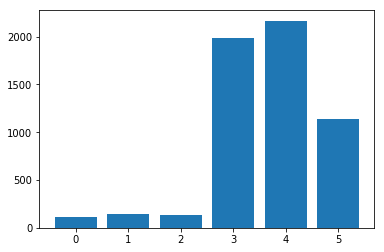

second_8


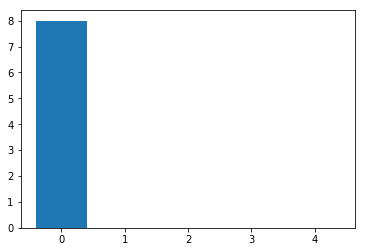

second_11


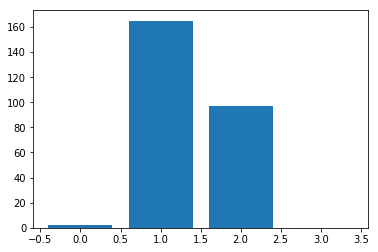

second_14


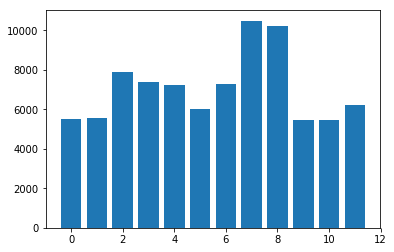

second_15


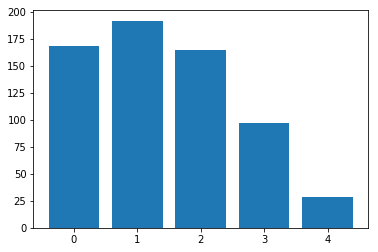

second_22


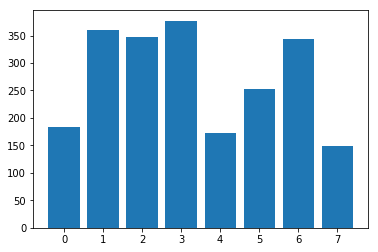

In [27]:
for key, arr in a.items():
    print(key)
    w = []
    for x,y in zip(arr, arr[1:]):
        w.append(gr[x, y])
        
    plt.bar(np.arange(len(w)), w)
    plt.show()

In [22]:
arr

[127, 79, 67, 81, 64, 59, 51]

In [25]:
strain 14 = 2 ng/ul
strain 7 = 1 ng/ul
strain 3 = 0.5 ng/ul
strain 5 = 0.25 ng/ul
strain 22 = 0.125 ng/ul
strain 15 = 0.0625 ng/ul
strain 21 = 0.031 ng/ul
strain 2 = 0.015 ng/ul
strain 8 = 0.007 ng/ul
strain 11 = 0.003 ng/ul

IndexError: tuple index out of range

In [30]:
for key, arr in a.items():
    print(key, np.median(arr))# np.median(sorted(arr)[1:-1]))
#     w = []
#     for x,y in zip(arr, arr[1:]):
#         w.append(gr[x, y])
        
#     plt.bar(np.arange(len(w)), w)
#     plt.show()

first_11 67.0
first_2 95.0
first_3 93.0
first_5 56.0
first_7 142.0
first_8 74.5
first_14 8.0
first_15 63.0
first_22 15.5
first_21 141.0
second_2 152.0
second_5 52.0
second_21 111.5
second_3 107.0
second_7 45.0
second_8 61.0
second_11 101.0
second_14 19.0
second_15 98.5
second_22 78.0


## EVal

In [27]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [29]:
restored_gr_filtered.shape

(500, 500)

In [30]:
answ_gr.shape

(500, 500)

In [31]:
gr.shape

(204, 204)

In [41]:
f1_score((answ_gr > 0).astype(int).flatten(), (restored_gr_filtered > 0).astype(int).flatten())

0.8353413654618473

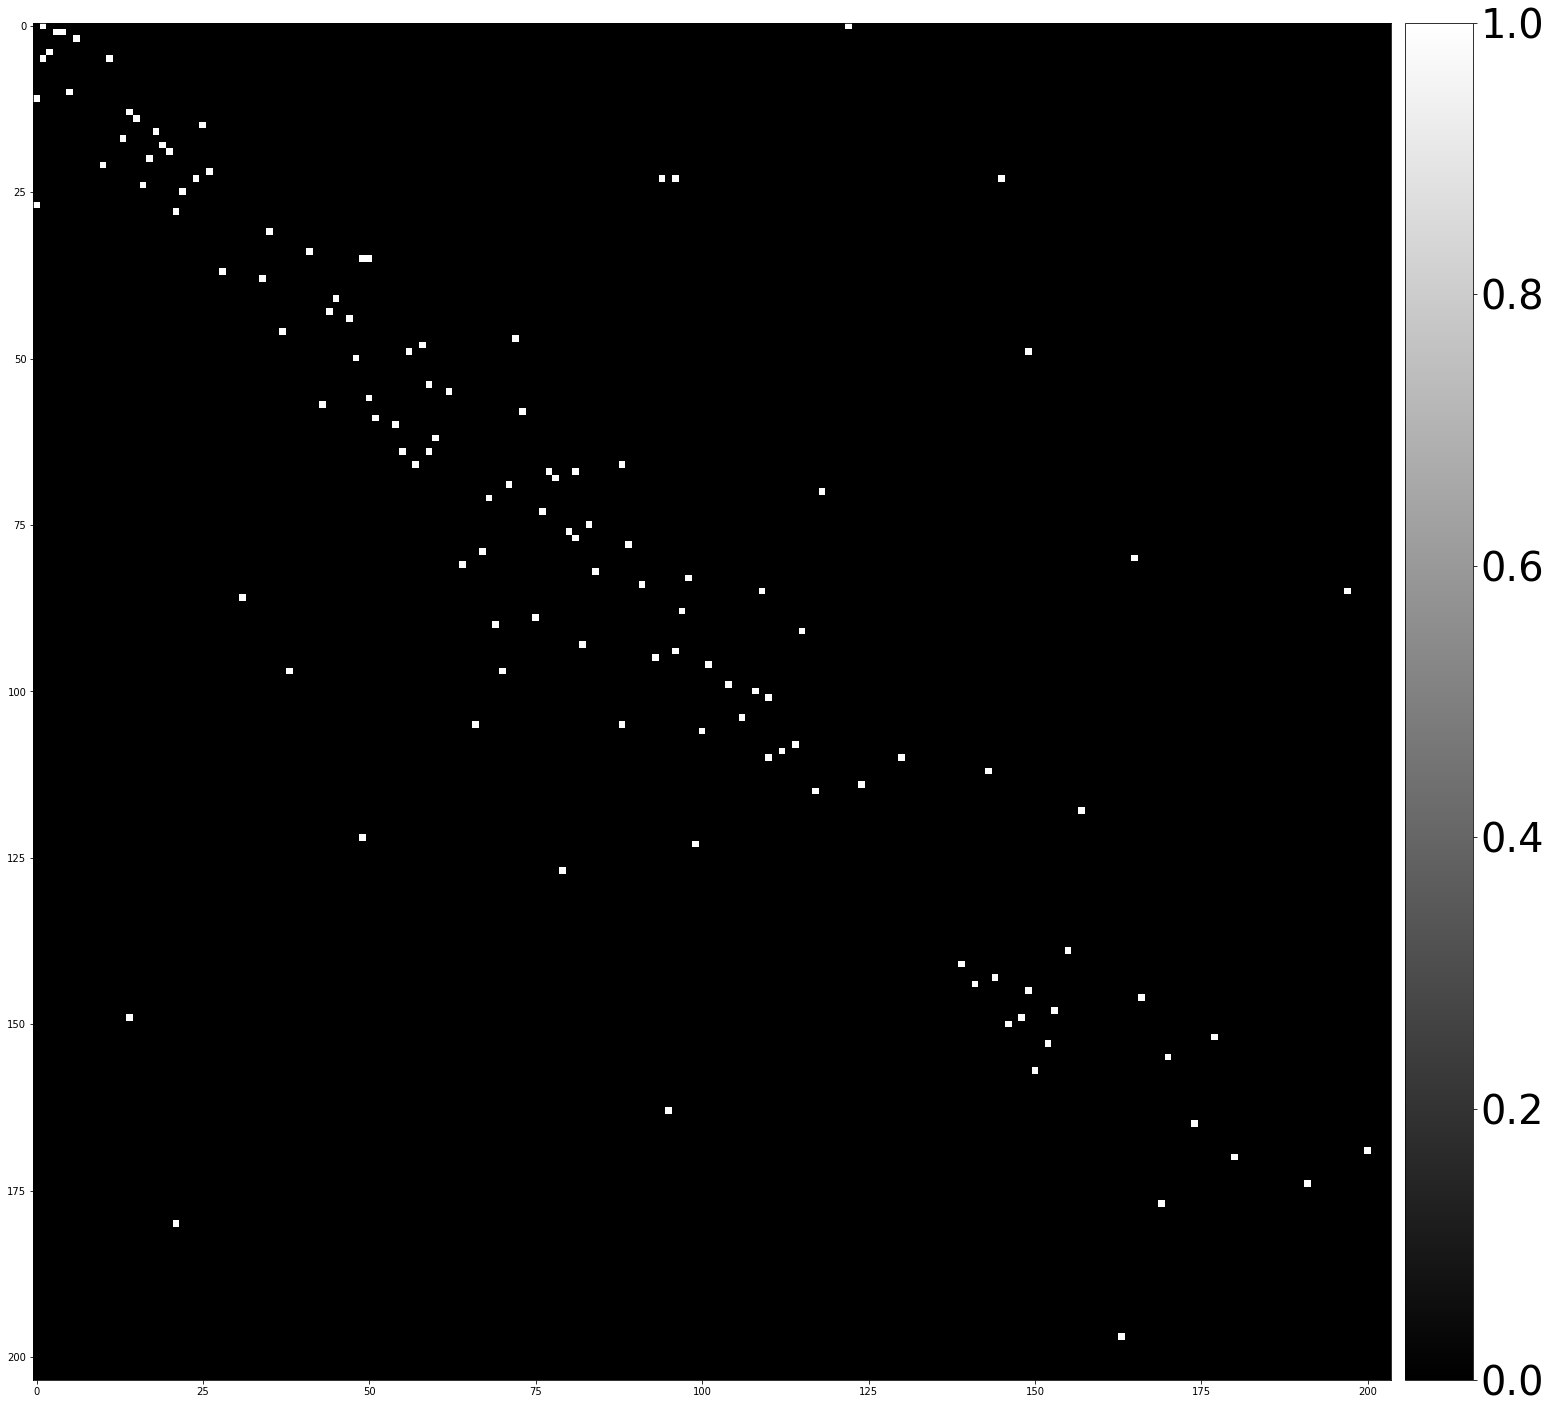

In [38]:
ca.plot_gr((answ_gr[:204, :204] > 0).astype(int))